In [1]:
from tools import manual_load_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import warnings
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

d = manual_load_data('clean_data.pkl')

In [35]:
def get_distance_matrix(xs, zs):
    if np.any(0.34 < xs < 0.87) or np.any(0.18 < zs < 0.48):
        warnings.warn('fixation falls out of the screen')
        
    paired = zip(xs, zs)
    d = cdist(paired, paired, 'euclidean')
    return d

def get_nearest_neighbour(dist):
    if dist.shape[0] != dist.shape[1]:
        raise Exception('Distance matrix should have square form, got {}'.format(dist.shape))
    elif np.any(dist.diagonal() != 0):
        raise Exception('Distance matrix should have 0 on its diagonal, got {}'.format(dist.diagonal()))
        
    np.fill_diagonal(dist, np.inf) # replace zeros with infinity on the diagonal
    idcs, mindist = dist.argmin(axis = 0), dist.min(axis = 0)
        
    return idcs, mindist

def R(fix_x, fix_z, A = 0.3 * 0.5):
    matrix = get_distance_matrix(fix_x, fix_z)
    idsc, mindist = get_nearest_neighbour(matrix)
    
    rho = len(mindist) / A
    R = 2 * np.sqrt(rho) * np.sum(mindist) / len(mindist)
    
    return R

In [31]:
x = d['P08']['trials']['t1']['fix']['centre_x']
y = d['P08']['trials']['t1']['fix']['centre_z']


m = get_distance_matrix(x, y)
idcs, mindist =  get_nearest_neighbour(m)
print 'R = {}'.format(R(x, y))

True
True
R = 0.182828774175


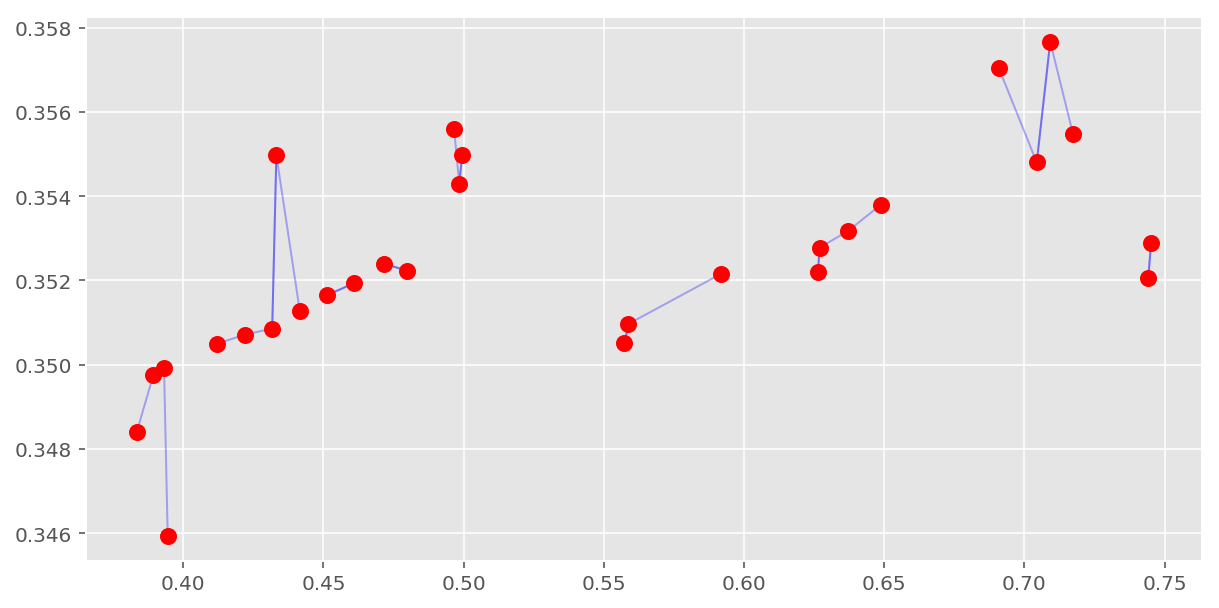

In [30]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(111)

for idx, closest in enumerate(idcs):
    ax.plot([x[idx], x[closest]], [y[idx], y[closest]], 'b-', linewidth = 1, alpha = 0.3)
ax.plot(x, y, 'r.', markersize = 15)
#     ax.annotate('',
#                xy = (x[idx], y[idx]), xycoords = 'data',
#                xytext = (x[closest], y[closest]), textcoords = 'data',
#                arrowprops = {'arrowstyle': '-|>', 'color':'b', 'linewidth':1})
    
#     ax.text(x[idx], y[idx], '{:.3f}'.format(mindist[idx]),
#             horizontalalignment='center', verticalalignment='center', color = 'k')
# plt.savefig('plot.png', dpi = 300)
# ax.set_aspect('equal', 'datalim')
plt.show()

In [36]:
table = pd.DataFrame()

for subj_id, subj in d.items():
    for trial_id, trial in subj['trials'].items():
        r = R(trial['fix']['centre_x'], trial['fix']['centre_z'])
        to_add = pd.Series({'participant': subj_id, 'condition': trial['name'][6:-4], 'trial':trial_id, 'R': r})
        table = table.append(to_add, ignore_index = True)

In [46]:
anova_table = table.groupby(['participant', 'condition']) \
                   .aggregate(np.mean) \
                   .reset_index() \
                   .pivot(index = 'participant', columns = 'condition', values = 'R')

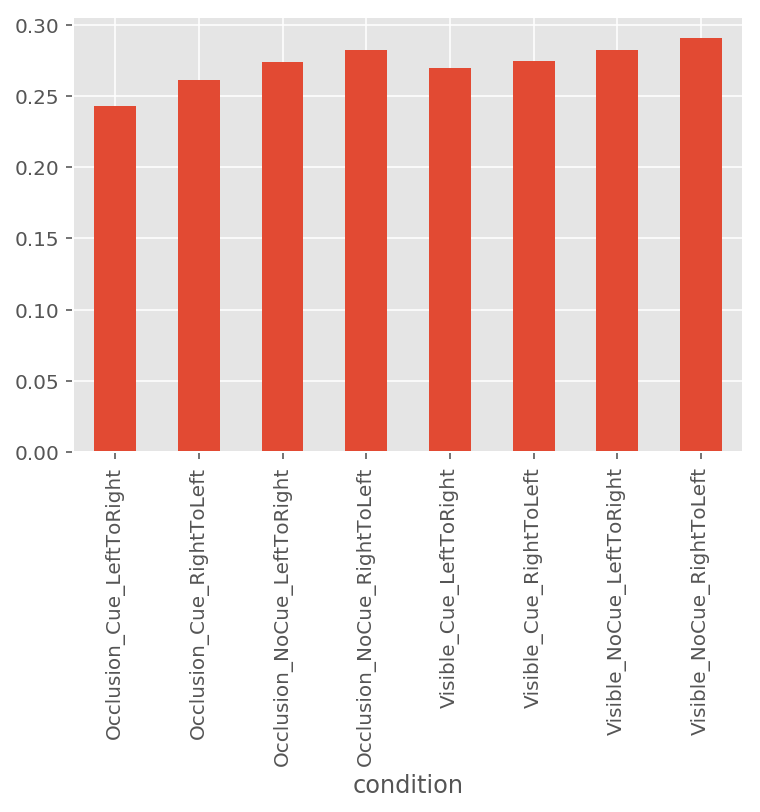

In [49]:
anova_table.mean(axis = 0).plot(kind = 'bar')